# Robotique Mobile - Travail Pratique 3

**N.B. _Il est bien important de lire l'énoncé du travail pratique au complet avant de commencer._**

**N.B. _Vous devrez produire du code. Nous avons indiqué les endroits à compléter à l'aide de TODO. Il y a aussi des questions d'analyse à répondre directement dans ce document._**

# Question 2 - RRT




In [2]:
import pathlib
from typing import List, Optional

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree


## Question 2.1 - RRT

En guise de première étape, nous allons implémenter l'algorithme Rapidly-exploring Random Trees (RRT) pour explorer une grille d'occupation.

Commençons par charger la carte de l'environnement.
Nous utiliserons la carte de l'environnement de test `world.png`.
Cette carte est une image en noir et blanc où les pixels noirs représentent les obstacles et les pixels blancs représentent les zones libres.

Dans le devoir, vous serez amené à créer votre propre carte à l'aide d'un logiciel de dessin de votre choix.


In [3]:
def load_world(world_path: str) -> np.ndarray[bool]:
    # Convertir l'image en niveaux de gris et binariser
    return cv2.imread(world_path, cv2.IMREAD_GRAYSCALE) > 127


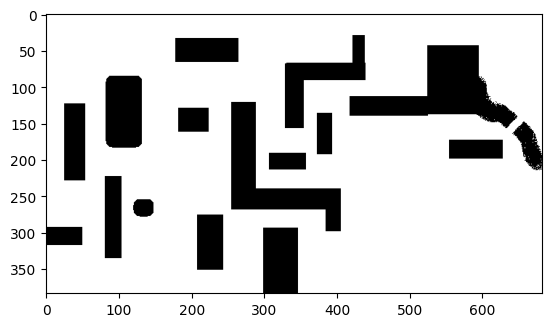

In [4]:
world = load_world('data/world.png')
plt.imshow(world, cmap='gray')
plt.show()

Pour implémenter l'algorithme RRT, nous devons définir quelques fonctions et classes utilitaires.

Commençons par définir une classe `Node` qui représente un noeud dans l'arbre RRT.

In [5]:
class Node:
    # Variable statique pour compter le nombre de noeuds et assigner un ID unique à chaque noeud
    NUM_NODES = 0

    def __init__(self, pos):
        """
        Noeud de l'arbre RRT
        :param pos: Position of the node
        """
        self.pos: np.ndarray = pos
        self.id: int = Node.NUM_NODES
        Node.NUM_NODES += 1

    def __str__(self):
        return f"Node {self.id} at {self.pos}"

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return self.id == other.id

    def __hash__(self):
        return hash(self.id)


Ensuite, nous allons définir la classe gérant le graphe de l'arbre RRT.

In [6]:
class Graph:
    def __init__(self):
        """
        Graphe de l'arbre RRT
        """
        self.vertices: dict[int, Node] = dict()
        self.edges: dict[int, List[int]] = dict()

    def __str__(self):
        return f"Graph with {len(self.vertices)} vertices and {sum(len(edges) for edges in self.edges.values())} edges"

    def __repr__(self):
        return self.__str__()

    def add_vertex(self, node: Node):
        """
        Ajoute un noeud au graphe
        :param node: Node à ajouter
        :return:
        """
        self.vertices[node.id] = node
        self.edges[node.id] = []

    def add_edge(self, node1: Node, node2: Node):
        """
        Ajoute une arête entre deux noeuds
        :param node1: Node 1
        :param node2: Node 2
        :return:
        """
        if node1.id not in self.vertices:
            raise ValueError(f"{node1} not in graph")
        if node2.id not in self.vertices:
            raise ValueError(f"{node2} not in graph")
        self.edges[node1.id].append(node2.id)
        self.edges[node2.id].append(node1.id)

    def get_nearest_vertex(self, pos: np.ndarray) -> Optional[Node]:
        """
        Retourne le noeud le plus proche de la position donnée
        :param pos: Position de la requête
        :return: Noeud le plus proche
        """
        min_dist = np.inf
        nearest_vertex = None
        for vertex in self.vertices.values():
            dist = np.linalg.norm(vertex.pos - pos)
            if dist < min_dist:
                min_dist = dist
                nearest_vertex = vertex
        return nearest_vertex

    def get_nearest_vertex_kdtree(self, pos: np.ndarray) -> Optional[Node]:
        """
        Retourne le noeud le plus proche de la position donnée en utilisant un KDTree
        N.B. : Cette fonction devrait être plus rapide que get_nearest_vertex pour un grand nombre de noeuds
        :param pos: Position de la requête
        :return: Noeud le plus proche
        """
        positions = np.array([vertex.pos for vertex in self.vertices.values()])
        tree = KDTree(positions)
        dist, idx = tree.query(pos)
        return list(self.vertices.values())[idx]

    def union(self, other):
        """
        Union de deux graphes
        :param other: Autre graphe
        :return: self
        """
        self.vertices.update(other.vertices)
        self.edges.update(other.edges)
        return self

    def path_between(self, start: Node, end: Node) -> List[Node]:
        """
        Retourne le chemin entre deux noeuds
        :param start:
        :param end:
        :return:
        """
        visited = set()
        queue = [(start, [start])]
        while queue:
            node, path = queue.pop(0)
            if node in visited:
                continue
            visited.add(node)
            if node == end:
                return path
            for neighbour_id in self.edges[node.id]:
                neighbour = self.vertices[neighbour_id]
                queue.append((neighbour, path + [neighbour]))
        return []


Définissons maintenant quelques fonctions utilitaires pour l'algorithme RRT.

La fonction suivante valide si un point est dans la carte. Il est important de noter la façon dont l'image est stocké dans le tableau numpy. La première dimension (le nombre de lignes) est l'axe y (la hauteur de l'image) et la deuxième dimension (le nombre de colonnes) est l'axe x (la largeur de l'image). Il faut donc inverser les axes pour accéder à un pixel de l'image.

In [7]:
def is_in_bounds(world: np.ndarray[bool], pos: np.ndarray) -> bool:
    """
    Returns whether the position is inside the world
    :param world: Matrix of the world (0 for free, 1 for obstacle)
    :param pos: Position to check
    :return: True if the position is inside the world
    """
    # TODO Vérifier si la position est dans la carte
    x, y = int(pos[0]), int(pos[1])
    return 0 <= x < world.shape[1] and 0 <= y < world.shape[0]

In [ ]:
# Test de la fonction is_in_bounds
assert is_in_bounds(world, np.array([150, 300])) == True
assert is_in_bounds(world, np.array([680, 200])) == True
assert is_in_bounds(world, np.array([700, 200])) == False
assert is_in_bounds(world, np.array([100, 400])) == False
# Vous pouvez ajouter d'autres tests si vous le souhaitez

La fonction suivante valide si un point est dans un obstacle. Encore une fois, il faut inverser les axes pour accéder à un pixel de l'image.

In [20]:
def is_in_obstacle(world: np.ndarray[bool], pos: np.ndarray) -> bool:
    """
    Retourne si la position est dans un obstacle
    :param world: Grille d'occupation (False = obstacle, True = zone libre)
    :param pos: Position à vérifier
    :return: True si dans un obstacle, False sinon
    """
    # TODO Vérifier si la position est dans un obstacle
    return not world[pos[1], pos[0]]


In [21]:
# Test de la fonction is_in_obstacle
assert is_in_obstacle(world, np.array([0, 0])) == False
assert is_in_obstacle(world, np.array([50, 150])) == True
# Vous pouvez ajouter d'autres tests si vous le souhaitez

On fournit la fonction suivante qui utilise [l'algorithme de Bresenham](https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm) pour valider que le chemin entre deux points est libre de tout obstacle.

In [22]:
def bresenham(x1, y1, x2, y2):
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    points = []
    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return np.array(points)

In [23]:
def can_connect(world: np.ndarray[bool], pos1: np.ndarray, pos2: np.ndarray) -> bool:
    """
    Vérifie si la ligne entre pos1 et pos2 est libre de tout obstacle
    :param world: Grille d'occupation (False = obstacle, True = zone libre)
    :param pos1: Première position
    :param pos2: Deuxième position
    :return: True si la ligne est libre de tout obstacle, False sinon
    """
    x1, y1 = np.round(pos1).astype(int)
    x2, y2 = np.round(pos2).astype(int)
    points = bresenham(x1, y1, x2, y2)
    for x, y in points:
        if not is_in_bounds(world, np.array([x, y])) or is_in_obstacle(world, np.array([x, y])):
            return False
    return True

Maintenant, utilisons ces fonctions pour définir `is_valid_conf` qui valide si une configuration est valide. Une configuration est valide si elle est dans les limites de la carte et que le chemin pour s'y rendre est libre de tout obstacle.

In [24]:
def is_valid_conf(world: np.ndarray[bool], from_pos: np.ndarray, to_pos: np.ndarray) -> bool:
    """
    Vérifie si une configuration est valide (dans les limites de la carte et sans obstacle entre les deux positions)
    :param world: Grill d'occupation (False = obstacle, True = zone libre)
    :param from_pos: Position de départ
    :param to_pos: Position d'arrivée
    :return: True si la configuration est valide, False sinon
    """
    # TODO Vérifier si la configuration est valide
    return is_in_bounds(world, from_pos) and can_connect(world, from_pos, to_pos)

In [25]:
# Test de la fonction is_valid_conf
assert is_valid_conf(world, np.array([0, 0]), np.array([50, 50])) == True
assert is_valid_conf(world, np.array([10, 50]), np.array([300, 120])) == True
assert is_valid_conf(world, np.array([0, 0]), np.array([100, 150])) == False
assert is_valid_conf(world, np.array([500, 300]), np.array([380, 100])) == True
assert is_valid_conf(world, np.array([250, 300]), np.array([500, 50])) == False
# Vous pouvez ajouter d'autres tests si vous le souhaitez

Nous sommes maintenant prêts à implémenter l'algorithme RRT.
Comme défini dans les notes de cours, l'algorithme utilise quelques sous-fonctions:
- `rand_conf` pour générer une configuration aléatoire
- `nearest_vertex` pour trouver le noeud le plus proche
- `new_conf` pour générer une nouvelle configuration à partir de deux positions et un pas
- `extend` pour étendre l'arbre avec une nouvelle configuration

Implémentons ces fonctions.

In [43]:
def rand_conf(world: np.ndarray[bool]) -> np.ndarray:
    """
    Génère une configuration aléatoire
    :param world: Grille d'occupation (False = obstacle, True = zone libre)
    :return: Configuration aléatoire
    """
    # TODO Générer une configuration aléatoire dans les limites de la carte
    return np.array([np.random.randint(0, world.shape[1]), np.random.randint(0, world.shape[0])])

In [45]:
# Test de la fonction rand_conf
for _ in range(100):
    conf = rand_conf(world)
    assert is_in_bounds(world, conf) == True

In [46]:
def nearest_vertex(graph: Graph, pos: np.ndarray) -> Node:
    """
    Retourne le noeud le plus proche de la position donnée
    :param graph: Graphe de l'arbre RRT
    :param pos: Position de la requête
    :return: Noeud le plus proche
    """
    # TODO Trouver le noeud le plus proche
    return graph.get_nearest_vertex_kdtree(pos)

In [47]:
# Test de la fonction nearest_vertex
graph = Graph()
n0 = Node(np.array([0, 0]))
n1 = Node(np.array([1, 1]))
n2 = Node(np.array([2, -1]))
n3 = Node(np.array([3, 2]))

graph.add_vertex(n0)
graph.add_vertex(n1)
graph.add_vertex(n2)
graph.add_vertex(n3)

graph.add_edge(n0, n1)
graph.add_edge(n1, n2)
graph.add_edge(n2, n3)

assert nearest_vertex(graph, np.array([-1, 0])) == n0
assert nearest_vertex(graph, np.array([1.5, 0])) == n1
assert nearest_vertex(graph, np.array([1.5, -1])) == n2
assert nearest_vertex(graph, np.array([2, 2])) == n3
assert nearest_vertex(graph, np.array([2, 10])) == n3
# Vous pouvez ajouter d'autres tests si vous le souhaitez

In [93]:

def new_conf(world: np.ndarray[bool], from_pos: np.ndarray, to_pos: np.ndarray, step_size: float) -> (bool, Node):
    """
    Génère une nouvelle configuration à partir de from_pos vers to_pos avec un pas donné
    La fonction retourne un tuple (is_valid, new_pos) où is_valid est True si la nouvelle configuration est valide
    :param world: Grille d'occupation (False = obstacle, True = zone libre)
    :param from_pos: Position de départ
    :param to_pos: Position d'arrivée
    :param step_size: Taille du pas
    :return: Tuple (is_valid, nouvelle_position), nouvelle_position est de type Node
    """
    # TODO Générer une nouvelle configuration
    return (is_valid_conf(world, from_pos, to_pos), Node(np.array(from_pos+((to_pos-from_pos)/np.linalg.norm(to_pos-from_pos)))*step_size))

In [92]:
# Test de la fonction new_conf
valid_1, node_1 = new_conf(world, np.array([0, 0]), np.array([10, 0]), 1)
assert valid_1 == True
assert (node_1.pos == np.array([1, 0])).all()

valid_2, node_2 = new_conf(world, np.array([0, 0]), np.array([200, 300]), 200)
assert valid_2 == False

valid_3, node_3 = new_conf(world, np.array([0, 0]), np.array([10, 0]), 100)
assert valid_3 == True
assert (node_3.pos == np.array([100, 0])).all()
# Vous pouvez ajouter d'autres tests si vous le souhaitez

[1. 0.]
[110.94003925 166.41005887]
[100.   0.]


Après beaucoup de travail, nous sommes enfin prêts à implémenter la fonction `extend` qui étend l'arbre RRT.
Complétez la fonction `rrt`.

In [94]:
# Préparation pour l'affichage
fig_path = pathlib.Path("figs/rrt")
fig_path.mkdir(exist_ok=True, parents=True)

In [ ]:

def rrt(world: np.ndarray[bool], start: np.ndarray, max_iter: int, step_size: float, show: bool = False) -> Graph:
    """
    Rapidly-exploring Random Trees (RRT)
    :param world: Grille d'occupation (False = obstacle, True = zone libre)
    :param start: Position de départ
    :param max_iter: Nombre maximal d'itérations
    :param step_size: Taille du pas
    :return: Graphe de l'arbre RRT
    """
    G = Graph()
    start_node = Node(start)
    G.add_vertex(start_node)

    for k in range(max_iter):
        # TODO Appliquer un pas de l'algorithme RRT avec les fonctions définies précédemment
        q_rand = rand_conf(world)
        q_near = nearest_vertex(G, q_rand)
        is_valid, q_new = new_conf(world, q_near.pos, q_rand, step_size)

        # TODO Ajouter le noeud au graphe (et l'arête) si la configuration est valide
        if is_valid:
            print("on ajoute")
            G.add_vertex(q_new)
            G.add_edge(q_near, q_new)

        # Affichage
        if show:
            fig, ax = plt.subplots()
            ax.imshow(world, cmap='gray')
            ax.plot(start[0], start[1], 'ro', label='Start')
            ax.plot(q_rand[0], q_rand[1], 'rx', label='Random')
            ax.plot([q_near.pos[0], q_rand[0]], [q_near.pos[1], q_rand[1]], color='pink', linestyle='--',
                    label='Direction')
            ax.plot(q_near.pos[0], q_near.pos[1], 'go', label='Nearest')
            ax.plot(q_new.pos[0], q_new.pos[1], color='pink', marker='o', label='New')
            for node in G.vertices.values():
                for neighbour_id in G.edges[node.id]:
                    neighbour = G.vertices[neighbour_id]
                    ax.plot([node.pos[0], neighbour.pos[0]], [node.pos[1], neighbour.pos[1]], 'b')
            ax.legend()
            ax.set_title(f'RRT at {k}')
            plt.savefig(fig_path / f'{k:04d}.png')
            plt.close(fig)

    return G

In [101]:
# Vous pouvez inspecter `figs/rrt` pour voir les images générées
rrt(world, np.array([40, 50]), 100, 10, show=True)

Node 6647 at [407.97205026 506.0370866 ]
Node 6648 at [409.79602701 502.00944144]
Node 6649 at [409.66705228 497.4410744 ]
on ajoute
Node 6650 at [409.701425   502.42535625]
on ajoute
Node 6651 at [4090.68625885 4966.39896607]
Node 6652 at [408.40606622 505.41646108]
Node 6653 at [409.97925309 500.64382278]
Node 6654 at [4092.68004714 4965.2414417 ]
Node 6655 at [4087.59344461 4970.21471587]
Node 6656 at [409.97315766 499.26779349]
Node 6657 at [4101.61198177 4965.71695405]
Node 6658 at [409.88597659 498.494189  ]
on ajoute
Node 6659 at [4098.55332588 4964.58959065]
Node 6660 at [408.68243142 504.96138938]
on ajoute
Node 6661 at [4103.09888604 4966.75070834]
Node 6662 at [4101.55664554 4965.68573368]
Node 6663 at [4101.45768208 4965.63104546]
Node 6664 at [4103.47626037 4967.08394822]
Node 6665 at [409.4026585  503.40441084]
on ajoute
Node 6666 at [4101.42148854 4965.61140738]
Node 6667 at [409.31763277 503.6306638 ]
Node 6668 at [404.05661971 509.14023175]
Node 6669 at [4091.43231103 

Graph with 14 vertices and 26 edges

In [83]:
def show_rrt(graph: Graph, start_pos: np.ndarray, world: np.ndarray[bool]):
    fig, ax = plt.subplots()
    ax.imshow(world, cmap='gray')
    ax.plot(start_pos[0], start_pos[1], 'bo', label='Start')
    for node in graph.vertices.values():
        for neighbour_id in graph.edges[node.id]:
            neighbour = graph.vertices[neighbour_id]
            ax.plot([node.pos[0], neighbour.pos[0]], [node.pos[1], neighbour.pos[1]], 'b')
    plt.show()


on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute
on ajoute


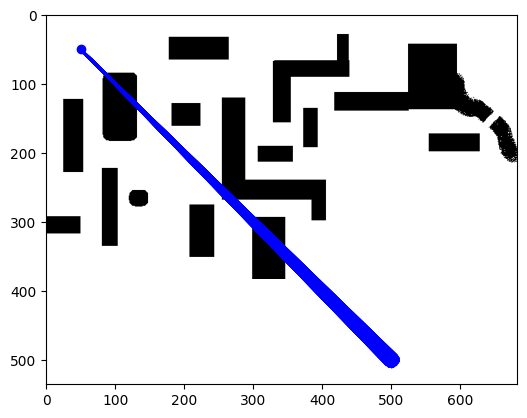

In [99]:
# Ne pas afficher permet d'exécuter rrt plus rapidement
start_pos = np.array([50, 50])
graph = rrt(world, start_pos, 1_000, 10)
# Affichage du graphe
show_rrt(graph, start_pos, world)

## Question 2.2 - RRT-Connect

Nous allons maintenant implémenter l'algorithme RRT-Connect.
L'algorithme RRT-Connect est une variante de RRT qui connecte deux arbres RRT en construisant un chemin entre eux.
Vous pouvez vous référer aux notes de cours pour plus de détails, ou à cette page [Robotic Motion Planning: RRT's de CMU](https://www.cs.cmu.edu/~motionplanning/lecture/lec20.pdf).


In [ ]:
# Préparation pour l'affichage
fig_path = pathlib.Path("figs/rrt_connect")
fig_path.mkdir(exist_ok=True, parents=True)

In [ ]:
def rrt_connect(world: np.ndarray[bool], start: np.ndarray, goal: np.ndarray, max_iter: int, step_size: float,
                show: bool = False) -> (Graph, Graph, Node, Node):
    """
    Rapidly-exploring Random Trees Connect (RRT-Connect)
    :param world: Grille d'occupation (False = obstacle, True = zone libre)
    :param start: Position de départ
    :param goal: Position d'arrivée
    :param max_iter: Nombre maximal d'itérations
    :param step_size: Taille du pas
    :param show: Afficher les étapes intermédiaires
    :return: (graph_a, graph_b, start_node, goal_node)
    """
    # Start graph
    graph_start = Graph()
    start_node = Node(start)
    graph_start.add_vertex(start_node)

    # Goal graph
    graph_goal = Graph()
    goal_node = Node(goal)
    graph_goal.add_vertex(goal_node)

    # Variables pour alterner entre les arbres
    graph_a, graph_b = graph_start, graph_goal
    for k in range(max_iter):
        # TODO Appliquer un pas de l'algorithme RRT-Connect pour le graphe graph_a
        q_a_rand = ...
        q_a_near = ...
        is_valid_a, q_a_new = ..., ...

        if not is_valid_a:
            # Si le pas n'est pas valide, on inverse les graphes et on recommence
            graph_a, graph_b = graph_b, graph_a
            continue

        # TODO Ajouter le noeud au graphe (et l'arête) si la configuration est valide
        ...

        # On extend maintenant graph_b vers q_a_new
        # TODO Trouver le noeud le plus proche de q_a_new dans graph_b
        q_b_near = ...
        while True:
            # TODO calculer la distance entre q_a_new et q_b_near
            distance = ...

            if distance < step_size and is_valid_conf(world, q_b_near.pos, q_a_new.pos):
                # Si la distance est plus petite que le pas et que le déplacement est valide, on peut connecter les deux arbres
                graph_a.union(graph_b)
                graph_a.add_edge(q_a_new, q_b_near)
                return graph_a, graph_b, start_node, goal_node

            # TODO Faire le pas vers q_b_new
            is_valid_b, q_b_new = ..., ...

            if not is_valid_b:
                # Si le pas n'est pas valide, on inverse les graphes et on recommence
                graph_a, graph_b = graph_b, graph_a
                break

            # TODO Ajouter le noeud au graphe (et l'arête) si la configuration est valide
            ...

            # Mise à jour pour la prochaine itération, q_b_new devient le nouveau noeud le plus proche q_b_near
            q_b_near = q_b_new

        # Affichage
        if show:
            fig, ax = plt.subplots()
            ax.imshow(world, cmap='gray')
            ax.plot(start[0], start[1], 'ro', label='Start')
            ax.plot(goal[0], goal[1], 'go', label='Goal')
            ax.plot(q_a_rand[0], q_a_rand[1], 'rx', label='Random')
            ax.plot([q_a_near.pos[0], q_a_rand[0]], [q_a_near.pos[1], q_a_rand[1]], color='pink', linestyle='--',
                    label='Direction')
            ax.plot(q_a_near.pos[0], q_a_near.pos[1], 'bo', label='Nearest A')
            ax.plot(q_a_new.pos[0], q_a_new.pos[1], color='pink', marker='o', label='New A')
            for node in graph_a.vertices.values():
                for neighbour_id in graph_a.edges[node.id]:
                    neighbour = graph_a.vertices[neighbour_id]
                    ax.plot([node.pos[0], neighbour.pos[0]], [node.pos[1], neighbour.pos[1]], 'b')
            for node in graph_b.vertices.values():
                for neighbour_id in graph_b.edges[node.id]:
                    neighbour = graph_b.vertices[neighbour_id]
                    ax.plot([node.pos[0], neighbour.pos[0]], [node.pos[1], neighbour.pos[1]], 'g')
            ax.legend()
            ax.set_title(f'RRT-Connect at {k}')
            plt.savefig(fig_path / f'{k:04d}.png')
            plt.close(fig)

    return graph_start, graph_goal, start_node, goal_node

In [ ]:
# Vous pouvez inspecter `figs/rrt_connect` pour voir les images générées
rrt_connect(world, np.array([50, 50]), np.array([600, 300]), 1_000, 20, show=True)

In [ ]:
def show_rrt_connect(graph_a: Graph, graph_b: Graph, start_node: Node, goal_node: Node, world: np.ndarray[bool]):
    path = graph_a.path_between(start_node, goal_node)
    fig, ax = plt.subplots()
    ax.imshow(world, cmap='gray')
    ax.plot(start_node.pos[0], start_node.pos[1], 'ro', label='Start')
    ax.plot(goal_node.pos[0], goal_node.pos[1], 'go', label='Goal')
    for node in graph_a.vertices.values():
        for neighbour_id in graph_a.edges[node.id]:
            neighbour = graph_a.vertices[neighbour_id]
            ax.plot([node.pos[0], neighbour.pos[0]], [node.pos[1], neighbour.pos[1]], 'b')

    if not path:
        for node in graph_b.vertices.values():
            for neighbour_id in graph_b.edges[node.id]:
                neighbour = graph_b.vertices[neighbour_id]
                ax.plot([node.pos[0], neighbour.pos[0]], [node.pos[1], neighbour.pos[1]], 'g')

    for i in range(len(path) - 1):
        ax.plot([path[i].pos[0], path[i + 1].pos[0]], [path[i].pos[1], path[i + 1].pos[1]], 'ro')

    fig.show()


In [ ]:
# Ne pas afficher permet d'exécuter rrt plus rapidement
start = np.array([100, 50])
goal = np.array([500, 300])
graph_a, graph_b, start_node, goal_node = rrt_connect(world, start, goal, 5_000, 20)

# Trouver le chemin entre les deux arbres
path = graph_a.path_between(start_node, goal_node)

# Affichage du graphe
show_rrt_connect(graph_a, graph_b, start_node, goal_node, world)

## Question 2.3 - Analyse



Dans cette section, vous devez répondre aux questions d'analyse ci-dessous.
Vous devrez utiliser les implémentations de RRT et RRT-Connect pour répondre à ces questions.
Dans les cellules de code, laisser les traces de code qui ont mené à vos réponses.
Dans les cellules de texte, rédiger vos réponses aux endroits indiqués.

### Autre carte
Dans les sections précédentes, nous avons utilisé une carte simple (`data/world.png`) pour tester nos algorithmes.
Nous allons maintenant utiliser une carte plus complexe pour tester nos algorithmes: la même carte que celle utilisée dans la question 1.
Dans la cellule ci-dessous, chargez la carte `data/world_q1.png` et affichez le résultat de `rrt`.


In [ ]:
# TODO Charger la carte data/world_q1.png et afficher le résultat de rrt
start_pos = np.array([50, 50])

# TODO Affichage du graphe
...

### Compromis entre le nombre d'itérations et la qualité de l'exploration

**Faites varier le nombre d'itérations de parmis `[100, 1000, 2000, 5000, 10_000]` pour l'algorithme RRT. Que remarquez-vous en termes de qualité de l'exploration? Comment expliquez-vous ce phénomène?**

TODO Votre réponse...


In [ ]:
# TODO code pour votre analyse

### Compromis entre la taille du pas et la qualité de l'exploration

**Faites varier la taille du pas de 1 à 100 (choisissez cinq valeurs de pas représentatifs à présenter) pour l'algorithme RRT. Que remarquez-vous en termes de qualité de l'exploration? Quel paramètre devez-vous ajuster pour obtenir une meilleure exploration?**

TODO Votre réponse...


In [ ]:
# TODO code pour votre analyse

### Compromis entre le nombre d'itérations et la qualité du chemin

**Faites varier le nombre d'itérations de `[100, 1000, 2000, 5000, 10_000]` pour l'algorithme RRT-Connect. Que remarquez-vous lorsque le nombre d'itérations varie? Pour un même nombre d'itérations, quelle différence observez-vous entre RRT et RRT-Connect?**

TODO Votre réponse...

In [ ]:
# TODO code pour votre analyse

### Compromis entre la taille du pas et la qualité du chemin [GLO-7021 seulement]

**Faites varier la taille du pas de 1 à 100 (choisissez cinq valeurs de pas représentatifs à présenter) pour l'algorithme RRT-Connect. Ajustez le nombre d'itérations pour chaque taille de pas pour que l'algorithme trouve un chemin. Que remarquez-vous en termes de qualité du chemin trouvé (sa longueur par exemple)? Comment expliquez-vous ce phénomène?**

TODO Votre réponse...

In [ ]:
# TODO code pour votre analyse

### Blocage de la planification de chemin [GLO-7021 seulement]

**Modifiez `data/world_q1.png` avec un logiciel d'édition d'images (e.g., GIMP, Pain.NET, Photoshop, etc.) et dessinez un obstacle qui bloque le chemin entre le point de départ et le point d'arrivée. Exécutez l'algorithme RRT-Connect sur cette nouvelle carte. Que se passe-t-il? Expliquez pourquoi l'algorithme ne trouve pas de chemin.**

TODO Votre réponse...



In [ ]:
# TODO code pour votre analyse

### Cas limites [GLO-7021 seulement]

**À partir de vos expérimentations avec RRT et RRT-Connect, concevez une carte où, malgré qu'un chemin existe entre le point de départ et le point d'arrivée, les algorithmes ont de la difficulté à le trouver. Expliquez pourquoi.**

TODO Votre réponse...


In [ ]:
# TODO code pour votre analyse